**This notebook extracts the two-photon calcium imaging data for a selected experiment. It outputs the following CSVs:**

pref_ori_ordered_subset.csv, the preferred orientation of each cell based on static grating stimuli

max_dff_subset_ordered.csv, the max dff at each NS presentation

mean_dff_subset_ordered.csv, the mean dff at each NS presentation

ns_stim_frame_presentation.csv, the frame numbers associated with each natural scene throughout the experiment

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import math
import statistics

from allensdk.core.brain_observatory_cache import BrainObservatoryCache

In [3]:
# We will create an instance of the Brain Observatory Cache as an object, "boc."
boc = BrainObservatoryCache(manifest_file='manifest.json')

In [4]:
boc.get_all_cre_lines()

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']

**SELECTING EXPERIMENT: by visual area and cre line**

In [5]:
# Assign visual area and cre line of interest for analysis 
visual_area = 'VISp'
cre_lines = boc.get_all_cre_lines()

# Get experiment contianers for visual area and cre line of interest 
exp_cont = boc.get_experiment_containers(targeted_structures=[visual_area], 
                                         cre_lines=cre_lines)

# Create an experiment dataframe 
exp_cont_df = pd.DataFrame(exp_cont)

# Check if dataframe is empty
if exp_cont_df.empty:
    print('Data frame is empty, choose another cre line & visual area combination.')
else:
    conditions = [
    (exp_cont_df['imaging_depth'] < 250),
    ((exp_cont_df['imaging_depth'] >= 250) & (exp_cont_df['imaging_depth'] < 365)),
    ((exp_cont_df['imaging_depth'] >= 365) & (exp_cont_df['imaging_depth'] < 550)),
    (exp_cont_df['imaging_depth'] >= 550)
    ]
    values = ["23", "4", "5", "6"]
    exp_cont_df['layer'] = np.select(conditions, values, default=np.nan)
    # Assign the ID column as the index and return dataframe
    exp_cont_df = exp_cont_df.set_index('id')
    
exp_cont_df

,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed,layer
id,,,,,,,,,
803589437,175,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),425496,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-425496,[],False,23
661437138,175,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),365251,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365251,[],False,23
511510736,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222426,Cux2-CreERT2;Camk2a-tTA;Ai93-222426,[],False,23
603576130,550,VISp,Ntsr1-Cre_GN220,Ai148(TIT2L-GC6f-ICL-tTA2),323982,Ntsr1-Cre_GN220;Ai148-323982,[],False,6
670396939,195,VISp,Pvalb-IRES-Cre,Ai162(TIT2L-GC6s-ICL-tTA2),369497,Pvalb-IRES-Cre;Ai162-369497,[],False,23
...,...,...,...,...,...,...,...,...,...
814796612,375,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),412366,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-412366,[],False,5
1018027599,225,VISp,Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),449653,Vip-IRES-Cre;Ai148-449653,[],False,23
957366099,375,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),476631,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-476631,[],False,5


In [6]:
exp_cont_df['imaging_depth'].unique()

array([175, 550, 195, 375, 275, 350, 400, 225, 185, 205, 200, 390, 265,
       285, 335])

In [7]:
exp_cont_df['layer'].unique()

array(['23', '6', '5', '4'], dtype=object)

In [8]:
subset_exp_cont_df = pd.DataFrame()
# for each unique imaging depth in dataframe, add first 2 entries to subset_exp_cont_df
for depth in exp_cont_df['imaging_depth'].unique():
    df = exp_cont_df[exp_cont_df['imaging_depth'] == depth].head(2)
    subset_exp_cont_df = subset_exp_cont_df.append(df)

subset_exp_cont_df.sort_values(by=['imaging_depth'])

,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed,layer
id,,,,,,,,,
803589437,175,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),425496,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-425496,[],False,23
661437138,175,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),365251,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365251,[],False,23
686449283,185,VISp,Pvalb-IRES-Cre,Ai162(TIT2L-GC6s-ICL-tTA2),379518,Pvalb-IRES-Cre;Ai162-379518,[],False,23
670396939,195,VISp,Pvalb-IRES-Cre,Ai162(TIT2L-GC6s-ICL-tTA2),369497,Pvalb-IRES-Cre;Ai162-369497,[],False,23
674679297,200,VISp,Pvalb-IRES-Cre,Ai162(TIT2L-GC6s-ICL-tTA2),373762,Pvalb-IRES-Cre;Ai162-373762,[],False,23
682734790,205,VISp,Slc17a7-IRES2-Cre,Ai94(TITL-GCaMP6s),377111,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111,[],False,23
688678764,205,VISp,Slc17a7-IRES2-Cre,Ai94(TITL-GCaMP6s),371307,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-371307,[],False,23
1022731531,225,VISp,Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),453991,Vip-IRES-Cre;Ai148-453991,[],False,23
1018028345,225,VISp,Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),457841,Sst-IRES-Cre;Ai148-457841,[],False,23


In [9]:
# save dataframe as csv file
subset_exp_cont_df.to_csv('../data/subset_exp_cont_df.csv')

In [10]:
# get unique ids
subset_exp_cont_df.index.unique()

Int64Index([ 803589437,  661437138,  603576130,  603425700,  670396939,
             614418789, 1040782478,  573720506,  511510675,  529763300,
             511507811,  637998953,  616886391, 1018028345, 1022731531,
             686449283,  688678764,  682734790,  674679297,  674802081,
             612044633,  575827179,  539291370,  531134088],
           dtype='int64', name='id')

In [11]:
# Assign experiment container id and stimuli 
# Note: experiment container id is the index of the dataframe
exp_container_ids = subset_exp_cont_df.index.unique()
stim = ['natural_scenes']

In [16]:
save_dirs = []
for exp_container_id in exp_container_ids:
    # Call experiment container for our id and stimuli of interest
    experiments = boc.get_ophys_experiments(experiment_container_ids = [exp_container_id],
                                       stimuli = stim)

    print(experiments)
    if experiments == []:
        print('No experiments found for experiment container id', exp_container_id)
        continue

    # get first experiment
    experiment = experiments[0]
    # Assign the experiment id
    experiment_id = experiment['id']

    layer = subset_exp_cont_df.loc[exp_container_id]['layer']
    save_dir = '../data/cont_' + \
        str(exp_container_id) + '_' \
        'exp_' + str(experiment_id) + \
        '_' + visual_area \
        + '_L' + layer + '/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_dirs.append(save_dir)
    print(save_dir)

    print('Downloading experiment data for', experiment_id)
    experiment_data = boc.get_ophys_experiment_data(experiment_id, )
    # # save experiment data as csv file
    # experiment_data.save(save_dir + 'experiment_data_.csv')
    print('Data acquired for', experiment_id)

[]
No experiments found for experiment container id 803589437


2023-12-10 13:59:26,917 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/662381825


[{'id': 662351346, 'imaging_depth': 175, 'targeted_structure': 'VISp', 'cre_line': 'Slc17a7-IRES2-Cre', 'reporter_line': 'Ai93(TITL-GCaMP6f)', 'acquisition_age_days': 96, 'experiment_container_id': 661437138, 'session_type': 'three_session_B', 'donor_name': '365251', 'specimen_name': 'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-365251', 'fail_eye_tracking': True}]
../data/cont_661437138_exp_662351346_VISp_L23/
Data acquired for 662351346
[{'id': 603889825, 'imaging_depth': 550, 'targeted_structure': 'VISp', 'cre_line': 'Ntsr1-Cre_GN220', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 102, 'experiment_container_id': 603576130, 'session_type': 'three_session_B', 'donor_name': '323982', 'specimen_name': 'Ntsr1-Cre_GN220;Ai148-323982', 'fail_eye_tracking': True}]
../data/cont_603576130_exp_603889825_VISp_L6/


2023-12-10 14:00:56,750 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/604169536


Data acquired for 603889825


2023-12-10 14:02:32,477 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/603578952


[{'id': 603516552, 'imaging_depth': 550, 'targeted_structure': 'VISp', 'cre_line': 'Ntsr1-Cre_GN220', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 97, 'experiment_container_id': 603425700, 'session_type': 'three_session_B', 'donor_name': '323984', 'specimen_name': 'Ntsr1-Cre_GN220;Ai148-323984', 'fail_eye_tracking': False}]
../data/cont_603425700_exp_603516552_VISp_L6/
Data acquired for 603516552


2023-12-10 14:03:54,231 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/672687283


[{'id': 672674054, 'imaging_depth': 195, 'targeted_structure': 'VISp', 'cre_line': 'Pvalb-IRES-Cre', 'reporter_line': 'Ai162(TIT2L-GC6s-ICL-tTA2)', 'acquisition_age_days': 106, 'experiment_container_id': 670396939, 'session_type': 'three_session_B', 'donor_name': '369497', 'specimen_name': 'Pvalb-IRES-Cre;Ai162-369497', 'fail_eye_tracking': True}]
../data/cont_670396939_exp_672674054_VISp_L23/
Data acquired for 672674054


2023-12-10 14:04:37,145 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/614669943


[{'id': 614535829, 'imaging_depth': 375, 'targeted_structure': 'VISp', 'cre_line': 'Sst-IRES-Cre', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 104, 'experiment_container_id': 614418789, 'session_type': 'three_session_B', 'donor_name': '332396', 'specimen_name': 'Sst-IRES-Cre;Ai148(CAM)-332396', 'fail_eye_tracking': True}]
../data/cont_614418789_exp_614535829_VISp_L5/
Data acquired for 614535829
[]
No experiments found for experiment container id 1040782478


2023-12-10 14:05:24,656 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/575304793


[{'id': 574415929, 'imaging_depth': 275, 'targeted_structure': 'VISp', 'cre_line': 'Sst-IRES-Cre', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 92, 'experiment_container_id': 573720506, 'session_type': 'three_session_B', 'donor_name': '297620', 'specimen_name': 'Sst-IRES-Cre;Ai148(CAM)-297620', 'fail_eye_tracking': False}]
../data/cont_573720506_exp_574415929_VISp_L4/
Data acquired for 574415929


2023-12-10 14:05:46,277 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516803176


[{'id': 509962140, 'imaging_depth': 275, 'targeted_structure': 'VISp', 'cre_line': 'Rorb-IRES2-Cre', 'reporter_line': 'Ai93(TITL-GCaMP6f)', 'acquisition_age_days': 103, 'experiment_container_id': 511510675, 'session_type': 'three_session_B', 'donor_name': '228786', 'specimen_name': 'Rorb-IRES2-Cre;Camk2a-tTA;Ai93-228786', 'fail_eye_tracking': False}]
../data/cont_511510675_exp_509962140_VISp_L4/
Data acquired for 509962140


2023-12-10 14:08:43,249 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/530355166


[{'id': 529763302, 'imaging_depth': 350, 'targeted_structure': 'VISp', 'cre_line': 'Nr5a1-Cre', 'reporter_line': 'Ai93(TITL-GCaMP6f)', 'acquisition_age_days': 92, 'experiment_container_id': 529763300, 'session_type': 'three_session_B', 'donor_name': '250605', 'specimen_name': 'Nr5a1-Cre;Camk2a-tTA;Ai93-250605', 'fail_eye_tracking': False}]
../data/cont_529763300_exp_529763302_VISp_L4/
Data acquired for 529763302


2023-12-10 14:09:48,405 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514408402


[{'id': 500860585, 'imaging_depth': 350, 'targeted_structure': 'VISp', 'cre_line': 'Scnn1a-Tg3-Cre', 'reporter_line': 'Ai93(TITL-GCaMP6f)', 'acquisition_age_days': 102, 'experiment_container_id': 511507811, 'session_type': 'three_session_B', 'donor_name': '221470', 'specimen_name': 'Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-221470', 'fail_eye_tracking': True}]
../data/cont_511507811_exp_500860585_VISp_L4/
Data acquired for 500860585


2023-12-10 14:13:03,906 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/638801937


[{'id': 638754323, 'imaging_depth': 400, 'targeted_structure': 'VISp', 'cre_line': 'Fezf2-CreER', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 97, 'experiment_container_id': 637998953, 'session_type': 'three_session_B', 'donor_name': '339839', 'specimen_name': 'Fezf2-CreER;Ai148-339839', 'fail_eye_tracking': False}]
../data/cont_637998953_exp_638754323_VISp_L5/
Data acquired for 638754323


2023-12-10 14:13:57,830 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/636960079


[{'id': 636930038, 'imaging_depth': 400, 'targeted_structure': 'VISp', 'cre_line': 'Fezf2-CreER', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 109, 'experiment_container_id': 616886391, 'session_type': 'three_session_B', 'donor_name': '335660', 'specimen_name': 'Fezf2-CreER;Ai148(CAM)-335660', 'fail_eye_tracking': False}]
../data/cont_616886391_exp_636930038_VISp_L5/
Data acquired for 636930038
[]
No experiments found for experiment container id 1018028345
[]
No experiments found for experiment container id 1022731531


2023-12-10 14:14:24,765 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/691348130


[{'id': 691208363, 'imaging_depth': 185, 'targeted_structure': 'VISp', 'cre_line': 'Pvalb-IRES-Cre', 'reporter_line': 'Ai162(TIT2L-GC6s-ICL-tTA2)', 'acquisition_age_days': 91, 'experiment_container_id': 686449283, 'session_type': 'three_session_B', 'donor_name': '379518', 'specimen_name': 'Pvalb-IRES-Cre;Ai162-379518', 'fail_eye_tracking': False}]
../data/cont_686449283_exp_691208363_VISp_L23/
Data acquired for 691208363


2023-12-10 14:14:40,580 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/690761063


[{'id': 690045763, 'imaging_depth': 205, 'targeted_structure': 'VISp', 'cre_line': 'Slc17a7-IRES2-Cre', 'reporter_line': 'Ai94(TITL-GCaMP6s)', 'acquisition_age_days': 140, 'experiment_container_id': 688678764, 'session_type': 'three_session_B', 'donor_name': '371307', 'specimen_name': 'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-371307', 'fail_eye_tracking': True}]
../data/cont_688678764_exp_690045763_VISp_L23/
Data acquired for 690045763


2023-12-10 14:20:39,597 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/685507199


[{'id': 685494041, 'imaging_depth': 205, 'targeted_structure': 'VISp', 'cre_line': 'Slc17a7-IRES2-Cre', 'reporter_line': 'Ai94(TITL-GCaMP6s)', 'acquisition_age_days': 97, 'experiment_container_id': 682734790, 'session_type': 'three_session_B', 'donor_name': '377111', 'specimen_name': 'Slc17a7-IRES2-Cre;Camk2a-tTA;Ai94-377111', 'fail_eye_tracking': False}]
../data/cont_682734790_exp_685494041_VISp_L23/
Data acquired for 685494041


2023-12-10 14:23:59,586 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/675093337


[{'id': 675062364, 'imaging_depth': 200, 'targeted_structure': 'VISp', 'cre_line': 'Pvalb-IRES-Cre', 'reporter_line': 'Ai162(TIT2L-GC6s-ICL-tTA2)', 'acquisition_age_days': 93, 'experiment_container_id': 674679297, 'session_type': 'three_session_B', 'donor_name': '373762', 'specimen_name': 'Pvalb-IRES-Cre;Ai162-373762', 'fail_eye_tracking': False}]
../data/cont_674679297_exp_675062364_VISp_L23/
Data acquired for 675062364


2023-12-10 14:24:17,164 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/675093244


[{'id': 675067662, 'imaging_depth': 390, 'targeted_structure': 'VISp', 'cre_line': 'Fezf2-CreER', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 89, 'experiment_container_id': 674802081, 'session_type': 'three_session_B', 'donor_name': '374201', 'specimen_name': 'Fezf2-CreER;Ai148-374201', 'fail_eye_tracking': False}]
../data/cont_674802081_exp_675067662_VISp_L5/
Data acquired for 675067662
[{'id': 612546472, 'imaging_depth': 265, 'targeted_structure': 'VISp', 'cre_line': 'Sst-IRES-Cre', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 98, 'experiment_container_id': 612044633, 'session_type': 'three_session_B', 'donor_name': '332395', 'specimen_name': 'Sst-IRES-Cre;Ai148(CAM)-332395', 'fail_eye_tracking': True}]
../data/cont_612044633_exp_612546472_VISp_L4/


2023-12-10 14:25:24,858 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/612934695


Data acquired for 612546472
[{'id': 576373003, 'imaging_depth': 285, 'targeted_structure': 'VISp', 'cre_line': 'Sst-IRES-Cre', 'reporter_line': 'Ai148(TIT2L-GC6f-ICL-tTA2)', 'acquisition_age_days': 100, 'experiment_container_id': 575827179, 'session_type': 'three_session_B', 'donor_name': '296891', 'specimen_name': 'Sst-IRES-Cre;Ai148(CAM)-296891', 'fail_eye_tracking': False}]
../data/cont_575827179_exp_576373003_VISp_L4/


2023-12-10 14:26:21,840 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/576517122


Data acquired for 576373003
[{'id': 539291372, 'imaging_depth': 335, 'targeted_structure': 'VISp', 'cre_line': 'Nr5a1-Cre', 'reporter_line': 'Ai93(TITL-GCaMP6f)', 'acquisition_age_days': 119, 'experiment_container_id': 539291370, 'session_type': 'three_session_B', 'donor_name': '250606', 'specimen_name': 'Nr5a1-Cre;Camk2a-tTA;Ai93-250606', 'fail_eye_tracking': False}]
../data/cont_539291370_exp_539291372_VISp_L4/


2023-12-10 14:27:09,710 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/539669493


Data acquired for 539291372


2023-12-10 14:28:03,964 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/531599424


[{'id': 531342486, 'imaging_depth': 335, 'targeted_structure': 'VISp', 'cre_line': 'Scnn1a-Tg3-Cre', 'reporter_line': 'Ai93(TITL-GCaMP6f)', 'acquisition_age_days': 125, 'experiment_container_id': 531134088, 'session_type': 'three_session_B', 'donor_name': '246775', 'specimen_name': 'Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-246775', 'fail_eye_tracking': False}]
../data/cont_531134088_exp_531342486_VISp_L4/
Data acquired for 531342486


In [30]:
# save save_dirs as csv file
save_dirs_df = pd.DataFrame(save_dirs)
save_dirs_df.to_csv('../data/save_dirs.csv')
save_dirs

['../data/cont_661437138_exp_662351346_VISp_L23/',
 '../data/cont_603576130_exp_603889825_VISp_L6/',
 '../data/cont_603425700_exp_603516552_VISp_L6/',
 '../data/cont_670396939_exp_672674054_VISp_L23/',
 '../data/cont_614418789_exp_614535829_VISp_L5/',
 '../data/cont_573720506_exp_574415929_VISp_L4/',
 '../data/cont_511510675_exp_509962140_VISp_L4/',
 '../data/cont_529763300_exp_529763302_VISp_L4/',
 '../data/cont_511507811_exp_500860585_VISp_L4/',
 '../data/cont_637998953_exp_638754323_VISp_L5/',
 '../data/cont_616886391_exp_636930038_VISp_L5/',
 '../data/cont_686449283_exp_691208363_VISp_L23/',
 '../data/cont_688678764_exp_690045763_VISp_L23/',
 '../data/cont_682734790_exp_685494041_VISp_L23/',
 '../data/cont_674679297_exp_675062364_VISp_L23/',
 '../data/cont_674802081_exp_675067662_VISp_L5/',
 '../data/cont_612044633_exp_612546472_VISp_L4/',
 '../data/cont_575827179_exp_576373003_VISp_L4/',
 '../data/cont_539291370_exp_539291372_VISp_L4/',
 '../data/cont_531134088_exp_531342486_VISp_

**OBTAIN STIMULUS EPOCH FRAMES & CALCIUM IMAING TRACES**

In [8]:
# stimuli presented during each epoch: start and end frame #s for each stimulus epoch
stimulus_epoch_df=experiment_data.get_stimulus_epoch_table()
stimulus_epoch_df

,stimulus,start,end
0,static_gratings,736,15225
1,natural_scenes,16131,30619
2,spontaneous,30769,39672
3,natural_scenes,39673,54159
4,static_gratings,55065,69551
5,natural_movie_one,70457,79510
6,natural_scenes,80417,96335
7,static_gratings,97618,113932


In [9]:
# ts = timestamp (frame), dff=∆F/F at each frame
ts, dff = experiment_data.get_dff_traces()

In [10]:
len(ts) # number of frames in experiment

114159

I'm making the assumption that there are extra frames at end of stimulus epoch that account for last few hundred frames of mice just chilling

**OBTAIN LIST OF NATURAL SCENE STIMULI IN ORDER OF PRESENTATION**

In [11]:
# start and end frames for each stimulus epoch

ns_start1=stimulus_epoch_df.loc[1]['start']
ns_end1=stimulus_epoch_df.loc[1]['end']

ns_start2=stimulus_epoch_df.loc[3]['start']
ns_end2=stimulus_epoch_df.loc[3]['end']

ns_start3=stimulus_epoch_df.loc[6]['start']
ns_end3=stimulus_epoch_df.loc[6]['end']

In [12]:
# img=experiment_data.get_stimulus(17000)[1]
# experiment_data.get_stimulus(17000)

In [13]:
# making list of images as np arrays (not super needed but still nice)

ns_img_list=[]

def get_ns(start, end):
    i=start
    while i < end:
        ns_img_list.append(experiment_data.get_stimulus(i)[1])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_ns(ns_start1, ns_end1)
get_ns(ns_start2, ns_end2)
get_ns(ns_start3, ns_end3)

In [14]:
# number of natural scenes shown in the experiment (there are 50 replicates for each natural scene)
len(ns_img_list)

5950

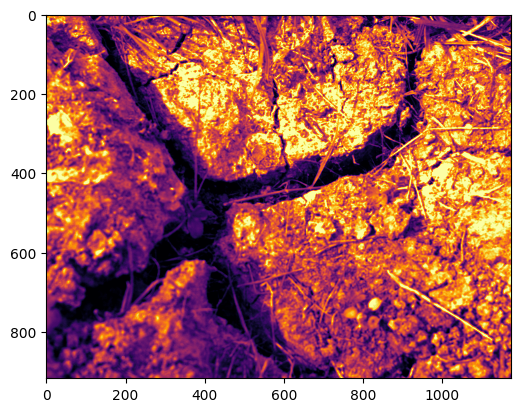

In [15]:
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize any image in the list
plt.imshow(ns_img_list[100], cmap='inferno')

**GET DFF TRACES FOR EACH FRAME**

In [16]:
# remember ts = list of each frame, dff = ∆F/F at each frame

dff_stim_all=[] # dff_stim_all is a list of MAX dff over the interval of ONE natural scene presentation for EACH CELL

def get_stim(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        max_dff_stim=max(cell_dff[i:j])
        dff_stim_cell.append(max_dff_stim)
        ts_in_next=experiment_data.get_stimulus(i)[0][2]['end']+1
        # start_next=experiment_data.get_stimulus(ts_in_next)[0][2]['start']
        i=ts_in_next

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_stim_cell=[]

    get_stim(ns_start1, ns_end1)
    get_stim(ns_start2, ns_end2)
    get_stim(ns_start3, ns_end3)

    dff_stim_all.append(dff_stim_cell)

In [17]:
experiment_data.get_stimulus(17031)[0][2]['start']

17029

In [18]:
# same idea, but doing mean dff over an interval

dff_stim_avg=[]

def get_stim_avg(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        avg_dff_stim=sum(cell_dff[i:j])/len(cell_dff[i:j])
        dff_stim_cell.append(avg_dff_stim)
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_stim_cell=[]

    get_stim_avg(ns_start1, ns_end1)
    get_stim_avg(ns_start2, ns_end2)
    get_stim_avg(ns_start3, ns_end3)

    dff_stim_avg.append(dff_stim_cell)

In [19]:
# Get the cell specimens information for this experiment
cell_specimens = boc.get_cell_specimens(experiment_container_ids=[exp_container_id])
cell_specimens_df = pd.DataFrame(cell_specimens)
# cell_specimens_df

**ORIENTATION PREFERENCE BASED ON STATIC GRATING DATA**

In [20]:
# Get experiment for our container id and stimuli of interest
stim_2 = ['static_gratings']
sg_experiment = boc.get_ophys_experiments(
                        experiment_container_ids = [exp_container_id],
                        stimuli = stim_2)

# Download the experiment data using the experiment id
experiment_id_2 = sg_experiment[0]['id']
data_sg = boc.get_ophys_experiment_data(experiment_id_2)

print('Data acquired.')

Data acquired.


In [21]:
from allensdk.brain_observatory.static_gratings import StaticGratings

# Create my StaticGratings Object 
sg = StaticGratings(data_sg)

# Return dataframe of peak conditions
sg_df = sg.peak
sg_df.head()

,ori_sg,sf_sg,phase_sg,reliability_sg,osi_sg,peak_dff_sg,ptest_sg,time_to_peak_sg,cell_specimen_id,p_run_sg,cv_os_sg,run_modulation_sg,sf_index_sg
0,3,2,3,0.084739,1.399099,8.395749,0.0,0.29853,662176419,NaN,0.850515,NaN,0.335852
1,4,4,1,0.005745,2.626179,1.122216,0.008574,0.16585,662174119,NaN,0.734866,NaN,0.184892
2,3,3,2,0.189009,1.424448,12.298211,0.0,0.3317,662176279,NaN,0.90373,NaN,0.229902
3,2,2,1,0.006267,1.099436,1.56066,0.000001,0.23219,662176337,NaN,0.510185,NaN,0.211963
4,0,2,3,-0.007346,0.662907,0.850199,0.016904,0.79608,662175871,NaN,0.310806,NaN,0.233975


In [22]:
cell_specimen_id=sg_df['cell_specimen_id']
num_cells=len(cell_specimen_id)

In [23]:
sg_df['ori_sg']
# values range from 0 to 5, I believe it is as follows:
# 0 = 0°, 1 = 30°, 2 = 60°, 3 = 90°, 4 = 120°, 5 = 150°

0      3
1      4
2      3
3      2
4      0
      ..
117    3
118    0
119    0
120    2
121    4
Name: ori_sg, Length: 122, dtype: object

In [24]:
# multiplying by 30 and adding to list of preferred orientations
pref_ori = []
for i in range(num_cells):
    pref_ori.append(sg_df['ori_sg'][i]*30)

In [25]:
pref_ori_dict={
    'cell_specimen_id': cell_specimen_id,
    'pref_ori': pref_ori
}
pref_ori_df=pd.DataFrame(pref_ori_dict)
pref_ori_df

,cell_specimen_id,pref_ori
0,662176419,90
1,662174119,120
2,662176279,90
3,662176337,60
4,662175871,0
...,...,...
117,662175744,90
118,662175479,0
119,662173899,0
120,662175035,60


make sure cells with preferred orientations also in natural scenes experiment and vice versa

In [26]:
cell_ids=experiment_data.get_cell_specimen_ids()

In [27]:
cell_spec_id_ori=[]
pref_ori_cell=[]

for i in range(len(pref_ori_df['cell_specimen_id'])):
    if pref_ori_df['cell_specimen_id'][i] in cell_ids:
        cell_spec_id_ori.append(pref_ori_df['cell_specimen_id'][i])
        pref_ori_cell.append(pref_ori_df['pref_ori'][i])

In [28]:
subset_pref_ori_dict={
    'cell_specimen_id': cell_spec_id_ori,
    'pref_ori': pref_ori_cell
}
subset_pref_ori_df=pd.DataFrame(subset_pref_ori_dict)
subset_pref_ori_df

,cell_specimen_id,pref_ori
0,662176419,90
1,662174119,120
2,662176279,90
3,662176337,60
4,662175871,0
...,...,...
117,662175744,90
118,662175479,0
119,662173899,0
120,662175035,60


**Extract osi_sg (orientation selectivity index) and sf_index_sg (????frequency selectivity index)**

In [29]:
osi_sg=sg_df['osi_sg']
fsi_sg=sg_df['sf_index_sg'] # there isn't any documentation stating that this is the selectivity index, but just running with it

si_dict={
    'cell_specimen_id': cell_specimen_id,
    'osi_sg': osi_sg,
    'fsi_sg': fsi_sg
}

si_df=pd.DataFrame(si_dict)

Text(0, 0.5, 'frequency selectivity index')

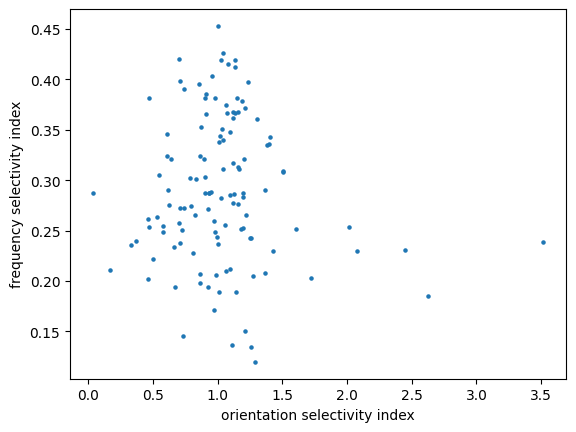

In [30]:
plt.scatter(osi_sg, fsi_sg, s=5)
plt.xlabel('orientation selectivity index')
plt.ylabel('frequency selectivity index')

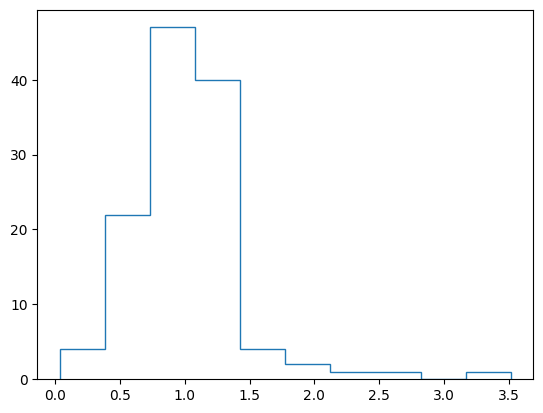

In [31]:
counts, bins = np.histogram(osi_sg)
plt.stairs(counts, bins)

**SUBSET CELLS IN CALCIUM DATA FOR NS TO COVER CELLS SHOWN SG**

In [32]:
cell_id_subset=[]
dff_subset=[]

for i in range(len(cell_ids)): #122
    if cell_ids[i] in cell_spec_id_ori:
        cell_id_subset.append(cell_ids[i])
        dff_subset.append(dff_stim_all[i])

In [33]:
# making a data frame
dff_subset_tuple=list(zip(cell_id_subset, dff_subset))
dff_subset_dict=dict(dff_subset_tuple)
dff_subset_df=pd.DataFrame(dff_subset_dict)

In [34]:
dff_subset_df_tp=dff_subset_df.transpose()
dff_subset_df_index=dff_subset_df_tp.reset_index()
dff_final_subset_df=dff_subset_df_index.rename(columns={'index':'cell_specimen_id'})

In [35]:
dff_final_subset_df.sort_values(by='cell_specimen_id')

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949
40,662173619,0.045412,0.130675,0.149010,0.137197,0.138913,0.095618,0.023891,0.060565,0.092005,...,0.153171,0.097204,0.040018,0.084626,0.158559,0.161222,0.072537,-0.028329,0.186743,0.102592
90,662173640,0.042221,0.056531,0.194425,0.107764,0.102339,0.115744,0.059223,0.050213,0.100294,...,0.075694,0.121137,0.084698,0.065006,0.062135,0.277913,0.201300,0.059730,0.192067,0.082821
29,662173743,0.116657,0.068082,0.070009,0.068791,0.034358,0.098918,0.146181,0.109095,0.114443,...,0.146335,0.025605,0.003635,0.016479,0.082197,0.042160,0.081064,0.083807,0.087966,0.059424
17,662173762,0.105657,0.159014,0.103676,0.031010,0.077767,0.114036,0.181438,0.078330,0.062279,...,0.105858,0.121696,0.129259,0.081384,0.138541,0.109978,0.164623,0.079721,0.142530,0.118364
87,662173815,-0.022448,0.107141,0.126217,0.187394,0.146566,0.122858,0.067843,0.030263,0.062793,...,0.065212,0.087915,0.065516,0.073486,0.071565,0.078175,0.054678,0.096120,0.068984,0.065472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,662177461,0.090964,0.083239,0.026911,0.129754,0.092818,0.128845,0.159662,0.188988,0.095747,...,0.164506,0.130830,0.072550,0.039231,0.008973,0.107735,0.040787,0.014737,0.080594,0.046671
91,662177481,0.010026,0.146954,0.051263,0.067341,0.545149,0.170128,0.149700,0.053619,0.000000,...,0.035932,0.103275,0.057943,0.034181,0.062692,0.073241,0.005353,0.071957,0.040968,0.013575
79,662177501,0.000000,0.094835,0.078234,0.079217,0.077016,0.046071,0.071132,0.050142,0.017796,...,0.060383,0.071584,0.015205,0.016702,0.055810,0.096333,0.079059,0.077031,0.090790,-0.001469
30,662177535,0.109150,0.108116,0.167361,0.097910,0.132500,0.031691,0.129355,0.138744,0.076127,...,0.035499,0.028410,0.114225,0.104637,0.085913,0.179405,0.142124,0.033516,0.004738,0.060591


SAME PROCESS, WITH MEAN DFF

In [36]:
cell_id_subset=[]
dff_mean_subset=[]

for i in range(len(cell_ids)): #122
    if cell_ids[i] in cell_spec_id_ori:
        cell_id_subset.append(cell_ids[i])
        dff_mean_subset.append(dff_stim_avg[i])

In [37]:
# making a data frame
mean_dff_subset_tuple=list(zip(cell_id_subset, dff_mean_subset))
mean_dff_subset_dict=dict(mean_dff_subset_tuple)
mean_dff_subset_df=pd.DataFrame(mean_dff_subset_dict)

In [38]:
mean_dff_final_subset_df=mean_dff_subset_df.transpose().reset_index().rename(columns={'index':'cell_specimen_id'})

In [39]:
mean_dff_final_subset_df

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949
0,662176419,-0.019267,-0.006937,0.041840,0.030350,0.021896,0.020096,-0.016199,-0.043854,-0.004576,...,-0.024055,0.698466,0.172262,0.090618,0.107497,0.037730,-0.003714,-0.024328,-0.042361,-0.035530
1,662174119,-0.042320,0.003180,0.028996,0.079057,0.106952,0.061256,0.015875,-0.034103,-0.023845,...,0.019708,0.023815,-0.021206,-0.003998,-0.018754,0.010474,0.002414,0.007788,0.002409,0.013833
2,662176279,-0.033596,0.004136,0.022926,0.050225,0.057515,0.068121,-0.025918,-0.036972,-0.050005,...,-0.022381,0.003818,0.010113,0.032256,0.037863,0.006228,-0.024978,-0.014685,0.027581,-0.002005
3,662176337,-0.007980,-0.002747,-0.023535,0.041787,-0.002290,0.052478,0.008000,0.046369,-0.057007,...,-0.026131,-0.025045,0.006657,0.038537,0.008890,0.023134,0.018482,-0.005322,0.002018,-0.033902
4,662175871,-0.022688,0.030380,0.024806,-0.027449,0.016391,0.005467,0.004258,-0.022219,0.005259,...,0.000471,-0.009348,0.004259,0.006058,0.023095,-0.012655,0.004814,0.002260,0.019391,0.002291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,662175744,-0.070732,0.067498,1.920539,1.256746,0.414816,0.219837,0.080529,-0.082132,-0.055465,...,-0.044161,0.031998,-0.007666,-0.010634,-0.000011,-0.003358,-0.002004,0.021750,-0.005745,0.046894
118,662175479,-0.022007,-0.039536,-0.042208,0.073250,0.129703,0.890399,0.214153,0.043299,-0.027756,...,0.002247,0.064149,0.028647,-0.037106,-0.027395,-0.042434,-0.020739,-0.064213,-0.021760,-0.017579
119,662173899,0.019996,-0.001445,-0.057968,-0.012685,0.008986,1.175099,0.618159,0.810485,0.319230,...,0.005366,0.025392,-0.018037,0.007083,0.025502,-0.002388,0.037282,0.037203,-0.016438,0.035163
120,662175035,-0.038189,-0.021430,0.012424,0.096663,0.067160,0.065452,0.003320,-0.066423,-0.036003,...,-0.033002,0.014460,0.036595,0.001598,-0.000098,-0.024626,0.004481,-0.008535,-0.007700,-0.008604


**List of frame numbers for each natural scene presentation (better than a list of actual images themselves)**

In [40]:
ns_frame_list=[]

def get_frames(start,end):
    i=start
    while i < end:
        ns_frame_list.append(experiment_data.get_stimulus(i)[0][2]['frame'])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_frames(ns_start1, ns_end1)
get_frames(ns_start2, ns_end2)
get_frames(ns_start3, ns_end3)

In [41]:
ns_frame_dict={
    'frame': ns_frame_list
}
ns_frame_df=pd.DataFrame(ns_frame_dict)

In [42]:
# NO LONGER NEEDED - making an ordered list of images based on frame list to have a key of some sort

frame_count=[]
nonrepeat_ns_img_list=[]

for i in range(len(ns_img_list)):
    if ns_frame_list[i] not in frame_count:
        frame_count.append(ns_frame_list[i])
        nonrepeat_ns_img_list.append(ns_img_list[i])

frame_img=list(zip(frame_count, nonrepeat_ns_img_list))

frame_img_ordered=['None']*len(frame_img)

for i in range(len(frame_img)):
    frame_img_ordered[int(frame_img[i][0])+1]=frame_img[i]

count, ordered_ns_img=list(zip(*frame_img_ordered))

In [43]:

# for i in range(len(count)):
#     if i < 10:
#         filename = f'./ns_img_npy/ns00{i}.npy'
#     if 10 <= i <100:
#         filename = f'./ns_img_npy/ns0{i}.npy'
#     if i >= 100:
#         filename = f'./ns_img_npy/ns{i}.npy'
#     np.save(filename, ordered_ns_img[i])

**EXPORT DATAFRAMES AS CSVs**

In [46]:
# preferred orientation for each cell (in order by cell specimen id)
ordered_pref_ori_subset=subset_pref_ori_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
ordered_pref_ori_subset.to_csv(save_dir + 'pref_ori_ordered_subset.csv', sep=',', index=False)

In [47]:
# max dff for each NS presentation (in order by cell specimen id)
ordered_dff_final_subset=dff_final_subset_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
ordered_dff_final_subset.to_csv(save_dir + 'max_dff_subset_ordered.csv', sep=',', index=False)

In [48]:
# mean dff for each NS presentation (in order by cell specimen id)
ordered_mean_dff_subset=mean_dff_final_subset_df.sort_values(by='cell_specimen_id').reset_index().drop(['index'], axis=1)
ordered_mean_dff_subset.to_csv(save_dir + 'mean_dff_subset_ordered.csv', sep=',', index=False)

In [49]:
# frame of each natural scene presented throughout the experiment
ns_stimulus_frame_presentation=ns_frame_df.to_csv(save_dir + 'ns_stim_frame_presentation.csv', sep=',', index=False)

**SOME NICE VISUALS FOR EXAMPLES / ILLUSTRATING IDEAS**

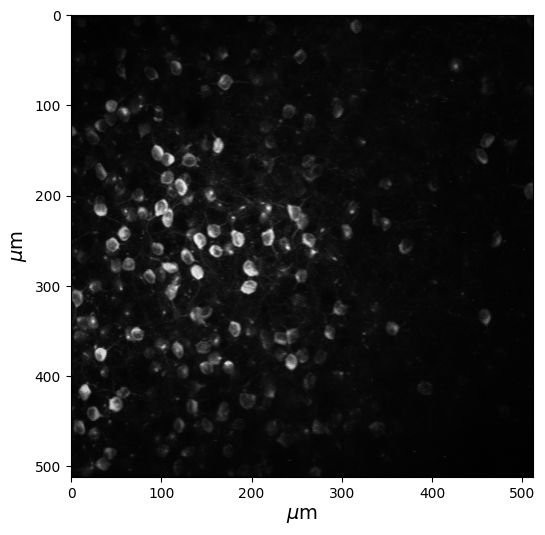

In [50]:
# Get the maximum projection (a numpy array) of our data
max_projection = experiment_data.get_max_projection()

# Create a new figure
fig = plt.figure(figsize=(6,6))

# Use imshow to visualize our numpy array
plt.imshow(max_projection, cmap='gray')

# Add labels for microns; weird syntax below is to get the micro sign
plt.ylabel(r'$\mu$m',fontsize=14)
plt.xlabel(r'$\mu$m',fontsize=14)
plt.show()

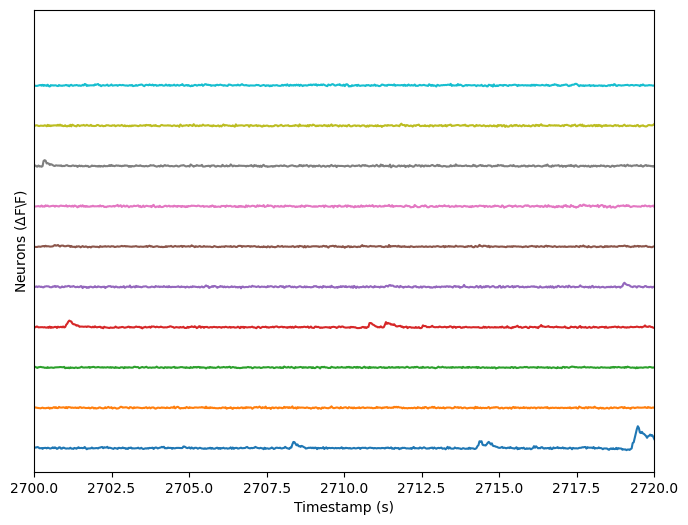

In [51]:
# Set up a figure
fig = plt.figure(figsize=(8,6))

# Loop through to add an offset on the y-axis
offset = 0
for cell in range(2,12):
    plt.plot(ts, dff[cell]+offset)
    offset+=5
    
plt.xlabel('Timestamp (s)')
plt.ylabel('Neurons ($\Delta$F\F)')
plt.yticks([])
plt.xlim([2700,2720])
plt.show()

**OBTAIN LIST OF STATIC GRATING STIMULI IN ORDER OF PRESENTATION, GET DFF TRACES FOR EACH FRAME**

In [52]:
# start and end frames for each stimulus epoch

sg_start1=stimulus_epoch_df.loc[0]['start']
sg_end1=stimulus_epoch_df.loc[0]['end']

sg_start2=stimulus_epoch_df.loc[4]['start']
sg_end2=stimulus_epoch_df.loc[4]['end']

sg_start3=stimulus_epoch_df.loc[7]['start']
sg_end3=stimulus_epoch_df.loc[7]['end']

In [53]:
experiment_data.get_stimulus(750)

((743,
  749.99,
  {'end': 750,
   'frame': nan,
   'orientation': 120.0,
   'phase': 0.0,
   'repeat': nan,
   'spatial_frequency': 0.1599999964237213,
   'start': 743,
   'stimulus': 'static_gratings'}),
 None)

In [54]:
# making dict (note, there are some random NaN in there... will deal with them)

ori_list=[]
freq_list=[]
phase_list=[]

def get_sg(start, end):
    i=start
    while i < end:
        ori_list.append(experiment_data.get_stimulus(i)[0][2]['orientation'])
        freq_list.append(experiment_data.get_stimulus(i)[0][2]['spatial_frequency'])
        phase_list.append(experiment_data.get_stimulus(i)[0][2]['phase'])
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

get_sg(sg_start1, sg_end1)
get_sg(sg_start2, sg_end2)
get_sg(sg_start3, sg_end3)

sg_exp_dict={
    'orientation': ori_list,
    'frequency': freq_list,
    'phase': phase_list
}

In [55]:
# remember ts = list of each frame, dff = ∆F/F at each frame

dff_max_sg=[] # a list of MAX dff over the interval of ONE static grating presentation for EACH CELL

def get_max(start, end):
    i=start
    while i < end:
        j=experiment_data.get_stimulus(i)[0][2]['end']
        max_dff_stim=max(cell_dff[i:j])
        dff_sg_cell.append(max_dff_stim)
        i=experiment_data.get_stimulus(i)[0][2]['end']+1

for k in range(len(dff)):
    
    cell_dff=dff[k]
    dff_sg_cell=[]

    get_max(sg_start1, sg_end1)
    get_max(sg_start2, sg_end2)
    get_max(sg_start3, sg_end3)

    dff_max_sg.append(dff_sg_cell)

In [56]:
# making a data frame
dff_sg_tuple=list(zip(cell_ids, dff_max_sg))


dff_sg_dict=dict(dff_sg_tuple)
dff_sg_df=pd.DataFrame(dff_sg_dict)

dff_sg_df_tp=dff_sg_df.transpose()
dff_sg_df_index=dff_sg_df_tp.reset_index()
dff_final_sg_df=dff_sg_df_index.rename(columns={'index':'cell_specimen_id'})
dff_final_sg_df=dff_final_sg_df.sort_values(by='cell_specimen_id').reset_index().drop(columns='index')
dff_final_sg_df

,cell_specimen_id,0,1,2,3,4,5,6,7,8,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,662173619,0.054001,0.106460,0.116898,0.118237,0.066857,0.078477,0.098583,0.015822,0.075225,...,0.091825,0.092675,0.106825,0.057194,0.048359,0.085397,0.148203,0.065090,0.063506,0.051771
1,662173640,0.070466,0.048549,0.026934,0.045304,0.126251,0.113245,0.133353,0.066588,0.042023,...,0.078361,0.117480,0.068463,0.125245,0.063585,0.053706,0.089330,0.008979,0.092373,0.090528
2,662173743,0.121961,0.131302,0.050170,0.054231,0.062125,0.109353,0.051779,0.035008,-0.017361,...,0.126604,0.174888,0.103347,0.144512,0.131420,0.096974,0.084248,0.046373,0.067210,0.079289
3,662173762,0.086996,0.129690,0.035702,0.088965,0.096300,0.036563,0.075541,0.073144,0.101051,...,0.036351,0.302182,0.173412,0.050883,0.163153,0.093465,0.057633,0.063827,0.099454,0.043663
4,662173815,0.117956,0.174305,0.113776,0.107958,0.162413,0.187592,0.043957,0.101175,0.025324,...,0.120809,0.079269,0.120528,0.046760,0.068295,0.013760,0.083623,0.116350,0.045364,0.030234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,662177461,0.055907,0.140619,0.154667,0.074747,0.075444,0.014203,0.058848,0.079440,0.021134,...,0.068123,0.178537,0.133524,0.110447,0.114732,0.055983,0.108140,0.082064,0.058999,0.052632
118,662177481,0.003524,0.135484,0.151746,0.071245,0.098230,0.050596,0.079520,-0.033918,0.019574,...,0.158979,0.062926,0.088901,0.114536,0.095479,0.099505,0.078890,0.062778,0.054062,0.099158
119,662177501,0.079349,0.017448,0.059821,0.079800,0.076447,0.030069,0.049545,0.025620,0.013337,...,0.077940,0.201635,0.192384,0.084677,0.064563,0.022009,-0.024874,-0.001315,0.036170,0.078686
120,662177535,0.307146,0.189965,0.118912,0.094175,0.024568,0.067705,0.100820,0.041694,0.069075,...,0.096751,0.224267,0.232068,0.051787,0.229045,0.067831,0.059229,0.068813,0.015143,0.144367


orientation/freq filtering adapted from pipeline for NS in analysis

In [57]:
# transpose df to prepare to associate with orientation and frequency data
dff_final_sg_df_t=dff_final_sg_df.T
dff_final_sg_df_t

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
cell_specimen_id,6.621736e+08,6.621736e+08,6.621737e+08,6.621738e+08,6.621738e+08,6.621738e+08,6.621738e+08,6.621739e+08,6.621739e+08,6.621739e+08,...,6.621773e+08,6.621774e+08,6.621774e+08,6.621774e+08,6.621774e+08,6.621775e+08,6.621775e+08,6.621775e+08,6.621775e+08,6.621776e+08
0,5.400135e-02,7.046620e-02,1.219608e-01,8.699615e-02,1.179559e-01,6.077044e-02,1.389162e-01,8.238029e-02,2.614332e-01,6.589285e-02,...,1.026219e-01,1.192254e-01,5.815500e-02,5.736043e-02,8.066943e-02,5.590719e-02,3.524055e-03,7.934860e-02,3.071463e-01,5.048133e-02
1,1.064598e-01,4.854925e-02,1.313020e-01,1.296897e-01,1.743049e-01,7.988630e-02,1.894701e-01,7.132252e-02,1.743142e-01,-1.545331e-02,...,7.161165e-02,7.560590e-02,1.424361e-01,3.339987e-01,2.867717e-02,1.406187e-01,1.354835e-01,1.744816e-02,1.899648e-01,6.097504e-02
2,1.168985e-01,2.693376e-02,5.016969e-02,3.570230e-02,1.137763e-01,8.550883e-02,9.760170e-02,9.797275e-02,7.384194e-02,1.307930e-02,...,4.389446e-02,6.736935e-02,1.462127e-01,2.114804e-01,1.181901e-01,1.546668e-01,1.517458e-01,5.982149e-02,1.189123e-01,3.683704e-02
3,1.182367e-01,4.530409e-02,5.423094e-02,8.896536e-02,1.079576e-01,9.759565e-02,1.307953e-01,1.342074e-01,1.735747e-01,4.122899e-02,...,6.011785e-02,1.542774e-01,7.288478e-02,4.847276e-02,-2.077581e-02,7.474691e-02,7.124454e-02,7.980036e-02,9.417479e-02,7.259858e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,8.539695e-02,5.370609e-02,9.697428e-02,9.346524e-02,1.376009e-02,1.751530e-01,5.847017e-02,1.331813e-01,8.907514e-02,1.199438e-01,...,3.396101e-02,1.187836e-01,1.106219e-01,6.977097e-02,1.495393e-01,5.598302e-02,9.950504e-02,2.200888e-02,6.783057e-02,1.944042e-02
5996,1.482027e-01,8.932959e-02,8.424782e-02,5.763333e-02,8.362284e-02,3.119014e-01,4.644833e-02,8.442865e-02,1.605821e-01,1.443224e-01,...,9.686641e-02,8.275700e-02,4.494481e-01,8.085056e-02,5.259963e-02,1.081402e-01,7.888988e-02,-2.487361e-02,5.922920e-02,1.583095e-01
5997,6.509045e-02,8.979383e-03,4.637288e-02,6.382675e-02,1.163501e-01,1.055816e-01,3.301562e-02,8.114805e-02,2.102207e-02,7.757737e-02,...,6.425872e-02,7.929555e-02,1.400645e-01,3.384039e-02,9.249864e-02,8.206396e-02,6.277785e-02,-1.314761e-03,6.881324e-02,1.046924e-01
5998,6.350598e-02,9.237273e-02,6.721033e-02,9.945400e-02,4.536396e-02,7.945877e-02,1.051251e-01,2.595896e-02,8.711436e-02,1.111205e-01,...,1.325020e-01,6.468438e-02,1.378474e-01,1.564516e-01,7.367857e-02,5.899883e-02,5.406213e-02,3.616952e-02,1.514309e-02,9.511402e-02


In [58]:
# produce a list of lists for the average MAX dff of each cell for each ORIENTATION (averaging across each replicate)

degrees=[0, 30, 60, 90, 120, 150]

avg_max_dff_ori_all=[] # a list of lists: 122 lists (one for each cell), avg max dff for each ori (len 6)

for j in range(len(dff_final_sg_df)): # for each cell
    
    img_max_dff_i=[[]for _ in range(len(degrees))] # empty list of 6 lists for each orientation
    
    for i in range(0, len(dff_final_sg_df_t)-1): # adding max dff scores, sorted into each list by frame number
        ori=ori_list[i]
        if math.isnan(ori):
            continue
        max_dff=dff_final_sg_df_t[j][i]
        img_max_dff_i[degrees.index(ori)].append(max_dff)

    avg_max_dff_i=[]
    
    for k in range(len(img_max_dff_i)):
        avg_max_dff=statistics.mean(img_max_dff_i[k])
        avg_max_dff_i.append(avg_max_dff)

    avg_max_dff_ori_all.append(avg_max_dff_i)

In [59]:
freq_unique=[]
for i in range(len(freq_list)):
    if freq_list[i] not in freq_unique:
        freq_unique.append(freq_list[i])
freq_unique_value=[]
for i in range(len(freq_unique)):
    if not math.isnan(freq_unique[i]):
        freq_unique_value.append(freq_unique[i])
sorted_freq=sorted(freq_unique_value)

In [60]:
# produce a list of lists for the average MAX dff of each cell for each FREQUENCY (averaging across each replicate)

avg_max_dff_freq_all=[] # a list of lists: 122 lists (one for each cell), avg max dff for each freq (len 5)

for j in range(len(dff_final_sg_df)): # for each cell
    
    img_max_dff_i=[[]for _ in range(len(sorted_freq))] # empty list of 6 lists for each orientation
    
    for i in range(0, len(dff_final_sg_df_t)-1): # adding max dff scores, sorted into each list by frame number
        freq=freq_list[i]
        if math.isnan(freq):
            continue
        max_dff=dff_final_sg_df_t[j][i]
        img_max_dff_i[sorted_freq.index(freq)].append(max_dff)

    avg_max_dff_i=[]
    
    for k in range(len(img_max_dff_i)):
        avg_max_dff=statistics.mean(img_max_dff_i[k])
        avg_max_dff_i.append(avg_max_dff)

    avg_max_dff_freq_all.append(avg_max_dff_i)

**compute significance of a peak in activity for each cell, metric is max dff / mean dff (not inclusive of max value) normalized**

In [61]:
ori_peak_sig=[]
freq_peak_sig=[]

def peak_sig(list_peak_sig, avg_max_dff):
    for j in range(len(avg_max_dff)):
        max_dff=max(avg_max_dff[j])
        list_mean_wo_max=[]
        for i in range(len(avg_max_dff[j])):
            if avg_max_dff[j][i] != max_dff:
                list_mean_wo_max.append(avg_max_dff[j][i])
        mean_wo_max=statistics.mean(list_mean_wo_max)
        peak_sig=max_dff/mean_wo_max
        list_peak_sig.append(peak_sig)

peak_sig(ori_peak_sig, avg_max_dff_ori_all)
peak_sig(freq_peak_sig, avg_max_dff_freq_all)

In [62]:
# make a dict with cell ids

peak_sig_dict={
    'cell_specimen_id': sorted(cell_ids),
    'ori_peak_sig': ori_peak_sig,
    'freq_peak_sig': freq_peak_sig
}

peak_sig_df=pd.DataFrame(peak_sig_dict)
peak_sig_df

,cell_specimen_id,ori_peak_sig,freq_peak_sig
0,662173619,1.028338,1.015319
1,662173640,1.031085,1.018286
2,662173743,1.017449,1.028437
3,662173762,1.015112,1.010331
4,662173815,1.510247,1.407497
...,...,...,...
117,662177461,1.107363,1.078399
118,662177481,1.068815,1.045134
119,662177501,1.114388,1.074849
120,662177535,1.463268,1.578733


Text(0, 0.5, 'frequency dff max/mean (exclusive of max)')

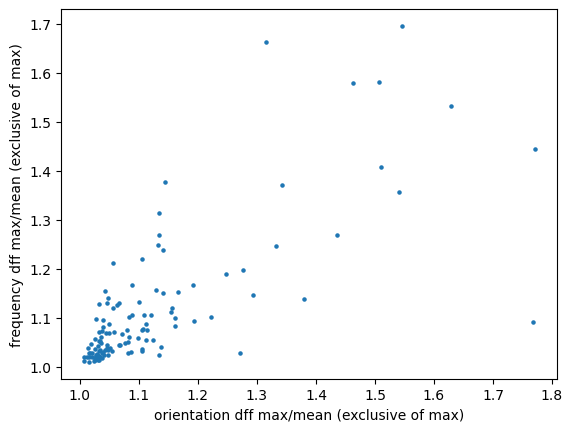

In [63]:
plt.scatter(ori_peak_sig, freq_peak_sig, marker="o", s=5)
plt.xlabel('orientation dff max/mean (exclusive of max)')
plt.ylabel('frequency dff max/mean (exclusive of max)')

In [64]:
sorted_sdk_osi_df=si_df.sort_values(by='cell_specimen_id')
sorted_sdk_osi_df['osi_sg']

40    1.178839
90    0.725951
29    1.139671
17    0.702779
87    1.000306
        ...   
74    1.364132
91    0.737335
79    1.109659
30    1.040683
28    1.158411
Name: osi_sg, Length: 122, dtype: object

In [65]:
sorted_sdk_osi_df.sort_values(by='osi_sg')

,cell_specimen_id,osi_sg,fsi_sg
96,662174183,0.034349,0.286824
15,662176759,0.1725,0.210457
13,662176944,0.329931,0.235559
53,662175972,0.372061,0.239942
75,662174603,0.458943,0.26138
...,...,...,...
21,662174367,2.017987,0.253093
27,662174293,2.075622,0.229291
71,662174520,2.447641,0.230526
1,662174119,2.626179,0.184892


Text(0, 0.5, 'sdk osi')

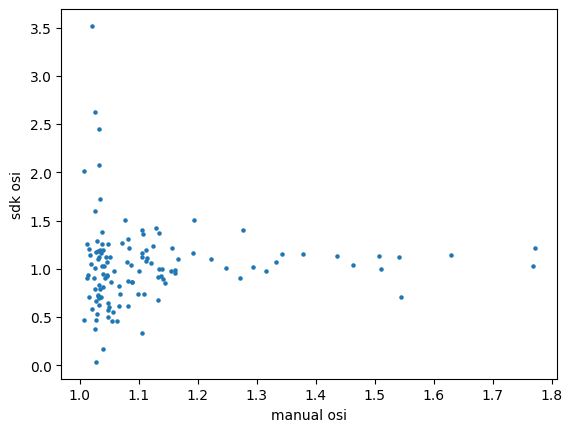

In [66]:
# x = np.random.rand(122)
# y = np.random.rand(122)
# colors = np.random.rand(122)

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
# b, a = np.polyfit(ori_peak_sig, sorted_sdk_osi_df['osi_sg'].tolist(), 1)

# # Create sequence of 100 numbers from 0 to 100 
# xseq = np.linspace(1, 1.8, num=100)

plt.scatter(ori_peak_sig, sorted_sdk_osi_df['osi_sg'].tolist(), s=5)
# plt.plot(xseq, a*xseq+b)

plt.xlabel('manual osi')
plt.ylabel('sdk osi')

In [67]:
counts, bins = np.histogram(ori_peak_sig, bins=20)
# plt.stairs(counts, bins)

In [68]:
# ori_peak_sig

In [69]:
# import s

In [70]:
a = np.log(np.array(ori_peak_sig)-1)


In [71]:
two_std_log=len(a[(a-np.mean(a)) > 2*np.std(a)])
one_std_log=len(a[(a-np.mean(a)) > 1*np.std(a)])

In [72]:
b = np.array(ori_peak_sig)

In [73]:
two_std_linear=len(b[(b-np.mean(b)) > 2*np.std(b)])
two_std_linear

9

In [74]:
one_std_linear=len(b[(b-np.mean(b)) > np.std(b)])
one_std_linear

15

In [75]:
two_std_linear_df=peak_sig_df.sort_values(by='ori_peak_sig', ascending=False).head(two_std_linear)
one_std_linear_df=peak_sig_df.sort_values(by='ori_peak_sig', ascending=False).head(one_std_linear)

In [76]:
two_std_linear_df.to_csv(save_dir + 'two_std_linear.csv', index=False)
one_std_linear_df.to_csv(save_dir + 'one_std_linear.csv', index=False)

(array([ 2.,  6., 13., 27., 18., 20., 16.,  7.,  6.,  7.]),
 array([-4.97917551, -4.50727053, -4.03536555, -3.56346057, -3.09155559,
        -2.61965061, -2.14774563, -1.67584064, -1.20393566, -0.73203068,
        -0.2601257 ]),
 <BarContainer object of 10 artists>)

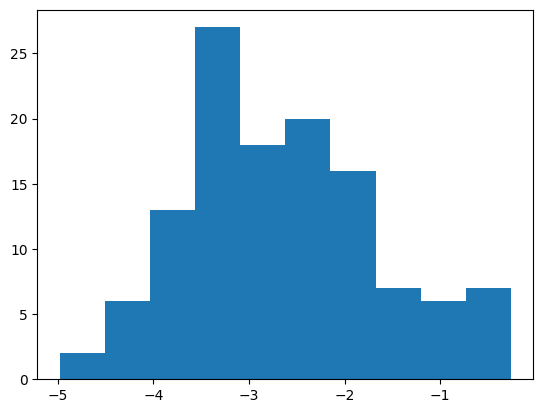

In [77]:
plt.hist(
    np.log(np.array(ori_peak_sig)-1)
)